<a href="https://colab.research.google.com/github/Theophine/Machine_Learning/blob/master/xgboost_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import all libraries and dependencies for dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# import all libraries and dependencies for data visualization
plt.rcParams['figure.figsize'] = [8,8]
pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')
sns.set(style='darkgrid')

In [2]:
import xgboost as xgb #xgboost package
from sklearn.model_selection import train_test_split #for splitting the data into training and testing dataset
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, plot_confusion_matrix   #for model validation
from sklearn.model_selection import GridSearchCV  #for cross validation 

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Telco-Customer-Churn.csv to Telco-Customer-Churn (1).csv


In [4]:
import pandas as pd
import io
df_churn = pd.read_csv(io.BytesIO(uploaded['Telco-Customer-Churn.csv']))

#Access dataframe

In [5]:
df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df_churn.shape

(7043, 21)

some data represents the response from people who had left the company. Therefore, we are going to drop these columns

In [7]:
for i, v in enumerate(df_churn):
  print(i, v)

0 customerID
1 gender
2 SeniorCitizen
3 Partner
4 Dependents
5 tenure
6 PhoneService
7 MultipleLines
8 InternetService
9 OnlineSecurity
10 OnlineBackup
11 DeviceProtection
12 TechSupport
13 StreamingTV
14 StreamingMovies
15 Contract
16 PaperlessBilling
17 PaymentMethod
18 MonthlyCharges
19 TotalCharges
20 Churn


any column with only one value or 85% of only one value must be removed

In [8]:
print(df_churn['SeniorCitizen'].unique())
print(df_churn['SeniorCitizen'].value_counts(dropna = False))

[0 1]
0    5901
1    1142
Name: SeniorCitizen, dtype: int64


#data wrangling 

Before you begin with data wrangling, make sure that you call the df.dtype attribute, that way you can tell a valid from an invalid value.

In [9]:
df_copy = df_churn.copy()

In [10]:
df_copy .dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

First observation, total charges is supposed to be a float but instead, it has the datatype of object. It is an indication that something is wrong with it. 

##access categorical variables to see how many values each have

Because having too many categorical variables would be computationally expensive

In [11]:
#print out the unique values of total charges 
df_copy ['TotalCharges'].nunique()

#there are a total of 6531 unique values which makes finding the text value difficults

6531

In [12]:
#we have to convert the total charges column to numeric 
pd.to_numeric(df_copy ['TotalCharges'])

ValueError: ignored

from the above error, it shows that there are blank space in certian cells in the 'Total charges' column. we need to fix this...

In [13]:
#how many cells have missing values in the Total charges columns
len(df_copy.loc[df_copy['TotalCharges'] == ' '])

11

In [14]:
#I will replace those blank values with np.nan and then interpolate to replace the nan values 
df_copy.loc[df_copy['TotalCharges'] == ' ', 'TotalCharges'] = np.nan

In [15]:
#Test code 
df_copy['TotalCharges'].value_counts(dropna = False)

NaN        11
20.2       11
19.75       9
20.05       8
19.65       8
           ..
253         1
2320.8      1
189.95      1
2763.35     1
4600.7      1
Name: TotalCharges, Length: 6531, dtype: int64

In [16]:
#convert the totalcharges columns to numeric and then interpolate the nan values 
df_copy['TotalCharges'] = pd.to_numeric(df_copy['TotalCharges'])

In [17]:
#Time to interpolate 
df_copy['TotalCharges'].interpolate(inplace = True)

In [18]:
#test code 
df_copy['TotalCharges'].value_counts(dropna = False)

20.20      11
19.75       9
19.65       8
19.90       8
20.05       8
           ..
8333.95     1
7171.70     1
2688.45     1
1673.80     1
1024.00     1
Name: TotalCharges, Length: 6541, dtype: int64

From the above, there are no more nan values 

##investigate other columns

In [19]:
df_copy['MultipleLines'].value_counts(dropna = False)

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [20]:
df_copy['InternetService'].value_counts(dropna = False)

Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64

In [21]:
df_copy['Contract'].value_counts(dropna = False)

Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64

In [22]:
df_copy['PaymentMethod'].value_counts(dropna = False)

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

##check for missing values

In [23]:
df_copy.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [24]:
df_copy.shape

(7043, 21)

##check for duplicates

In [25]:
df_copy .duplicated(subset= ['customerID']).sum()

0

From the above, there are no duplicate values and thus, the column customerID has to be dropped

In [26]:
df_copy .drop(['customerID'], axis = 1, inplace= True)

In [27]:
#test the code 
df_copy .shape

(7043, 20)

In [28]:
df_copy.replace(' ', '_', regex= True, inplace = True)

#split your dataset into predictors and target 

In [29]:
X = df_copy.drop('Churn', axis = 1).copy()
y = df_copy['Churn'].copy()

In [30]:
X.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

In [31]:
#change the data type of gender and seniorcitizen to category 
X['gender'] = X['gender'].astype('category')
X['SeniorCitizen'] = X['SeniorCitizen'].astype('category')

#OneHot encoding of the object and category column

In [32]:
X_encoded = pd.get_dummies(X, drop_first= True)
X_encoded.head(2)

,tenure,MonthlyCharges,TotalCharges,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No_phone_service,MultipleLines_Yes,InternetService_Fiber_optic,InternetService_No,OnlineSecurity_No_internet_service,OnlineSecurity_Yes,OnlineBackup_No_internet_service,OnlineBackup_Yes,DeviceProtection_No_internet_service,DeviceProtection_Yes,TechSupport_No_internet_service,TechSupport_Yes,StreamingTV_No_internet_service,StreamingTV_Yes,StreamingMovies_No_internet_service,StreamingMovies_Yes,Contract_One_year,Contract_Two_year,PaperlessBilling_Yes,PaymentMethod_Credit_card_(automatic),PaymentMethod_Electronic_check,PaymentMethod_Mailed_check
0,1,29.85,29.85,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
1,34,56.95,1889.50,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


In [33]:
X_encoded.shape

(7043, 30)

In [34]:
#Inspect the target column 
y.value_counts(dropna = False)

No     5174
Yes    1869
Name: Churn, dtype: int64

the data is imbalanced and thus must be balanced

time to split the data into train test split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2, random_state = 42, stratify = y)

#Model building stage

##instantiate the xgboost model

In [36]:
#instantiate xgboost 
xgb_clf = xgb.XGBClassifier(objective = 'binary:logistic', random_state= 42, missing = None)

In [37]:
#Quickly evaluate the performance of the model
xgb_model = xgb_clf.fit(X_train, y_train, eval_set = [(X_test, y_test)], eval_metric= 'auc', early_stopping_rounds= 10, verbose = True)

[0]	validation_0-auc:0.812018
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.823001
[2]	validation_0-auc:0.825553
[3]	validation_0-auc:0.829274
[4]	validation_0-auc:0.832842
[5]	validation_0-auc:0.831739
[6]	validation_0-auc:0.830776
[7]	validation_0-auc:0.832264
[8]	validation_0-auc:0.832948
[9]	validation_0-auc:0.835226
[10]	validation_0-auc:0.835574
[11]	validation_0-auc:0.834895
[12]	validation_0-auc:0.836417
[13]	validation_0-auc:0.837236
[14]	validation_0-auc:0.83838
[15]	validation_0-auc:0.839105
[16]	validation_0-auc:0.839173
[17]	validation_0-auc:0.838911
[18]	validation_0-auc:0.838596
[19]	validation_0-auc:0.838702
[20]	validation_0-auc:0.838612
[21]	validation_0-auc:0.839685
[22]	validation_0-auc:0.839991
[23]	validation_0-auc:0.840494
[24]	validation_0-auc:0.840783
[25]	validation_0-auc:0.841765
[26]	validation_0-auc:0.842082
[27]	validation_0-auc:0.841794
[28]	validation_0-auc:0.842069
[29]	validation_0-auc:0.842289
[30]	validation_0

In [38]:
#print the fitted model to see the parameters it used
xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

##Plot confusion matrix

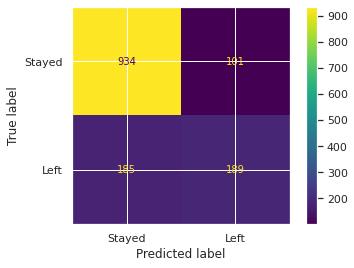

In [39]:
#evaluate the model using confusio matrix 
plot_confusion_matrix(xgb_model, X_test, y_test, values_format= 'd', display_labels= ['Stayed', 'Left'])
plt.show();

##Observation: Remember that we did not tune the hyperparameters and we did not balance the dataset which is why the model performed poorly. 

##Tune individual hyperparameters using yellow brick

In [40]:
#Testing for 'reg_alpha' (i.e., L1 regularization)

In [41]:
from yellowbrick.model_selection import ValidationCurve

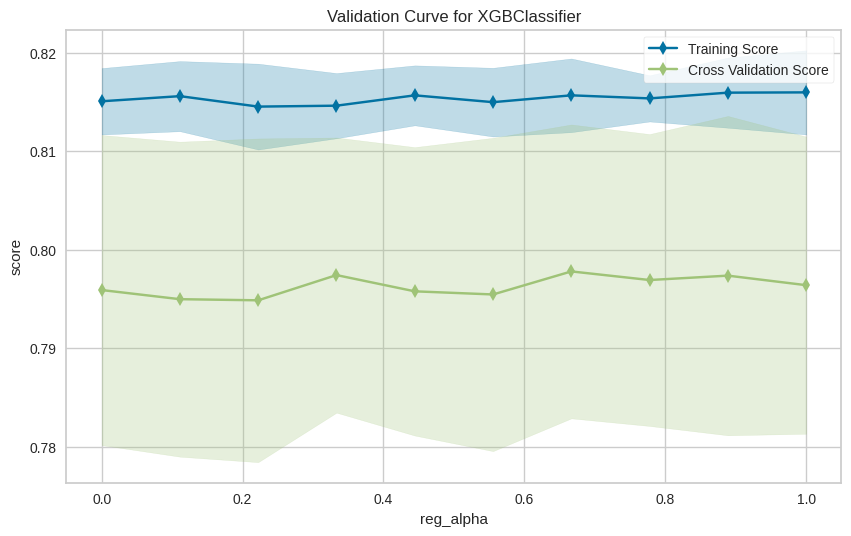

In [42]:
#find the best value for reg_alpha lambda
from sklearn.model_selection import StratifiedKFold

n_splits = StratifiedKFold(n_splits= 6)
fig, ax = plt.subplots(figsize = (10, 6), dpi = 100)
viz = ValidationCurve(xgb_model, param_name= 'reg_alpha', param_range= np.linspace(0, 1, 10), ax = ax, cv = n_splits, n_jobs = -1, scoring = 'f1_weighted')
viz.fit(X_train, y_train)
viz.poof();

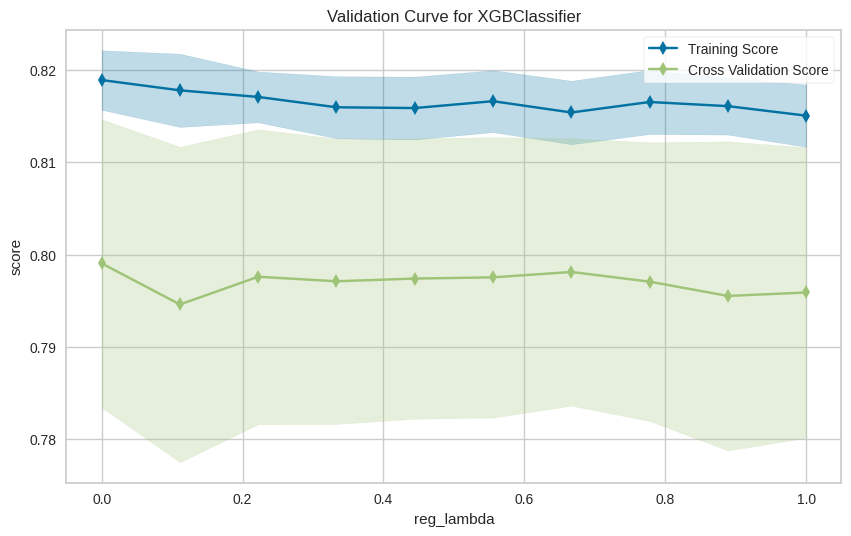

In [43]:
#find the best value for reg_lambda lambda (i.e., L2)
from sklearn.model_selection import StratifiedKFold

n_splits = StratifiedKFold(n_splits= 6)
fig, ax = plt.subplots(figsize = (10, 6), dpi = 100)

viz_lambda = ValidationCurve(xgb_model, param_name='reg_lambda', param_range= np.linspace(0, 1, 10), ax = ax, cv = n_splits, scoring= 'f1_weighted', n_jobs= -1)
viz_lambda.fit(X_train, y_train)
viz_lambda.poof();

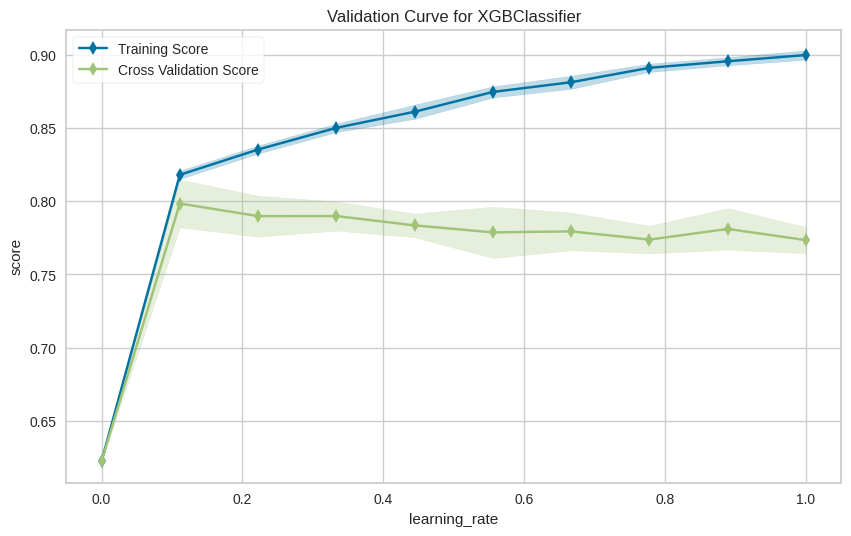

In [44]:
#we check for the learning rate 

from sklearn.model_selection import StratifiedKFold

n_splits = StratifiedKFold(n_splits= 6)
fig, ax = plt.subplots(figsize = (10, 6), dpi = 100)

viz_lambda = ValidationCurve(xgb_model, param_name='learning_rate', param_range= np.linspace(0, 1, 10), ax = ax, cv = n_splits, scoring= 'f1_weighted', n_jobs= -1)
viz_lambda.fit(X_train, y_train)
viz_lambda.poof();

inspect each scores and their ranges to see the best combination

In [45]:
viz_lambda.param_range[viz_lambda.test_scores_mean_.argmax()]

0.1111111111111111

next we check for the pruning parameter (gamma)

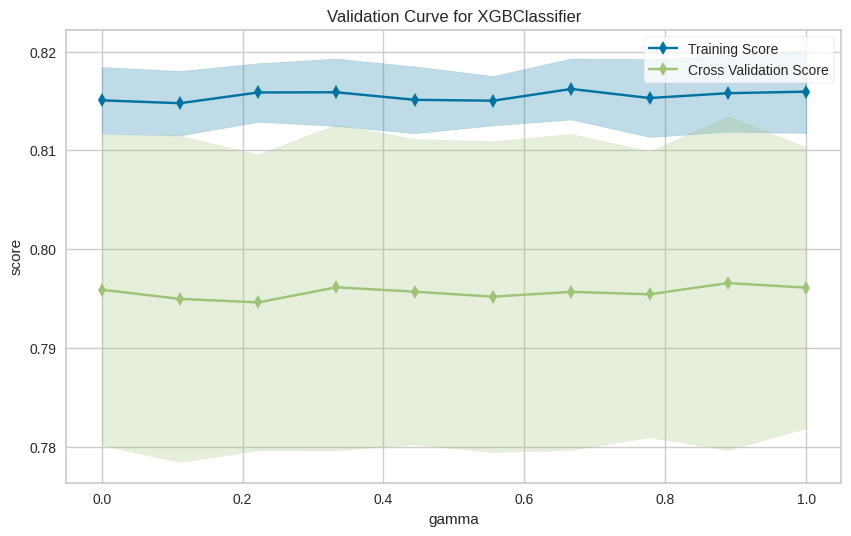

In [46]:
#we check for the prunning argument i.e., gamma

from sklearn.model_selection import StratifiedKFold

n_splits = StratifiedKFold(n_splits= 6)
fig, ax = plt.subplots(figsize = (10, 6), dpi = 100)

viz_gamma = ValidationCurve(xgb_model, param_name='gamma', param_range= np.linspace(0, 1, 10), ax = ax, cv = n_splits, scoring= 'f1_weighted', n_jobs= -1)
viz_gamma.fit(X_train, y_train)
viz_gamma.poof();

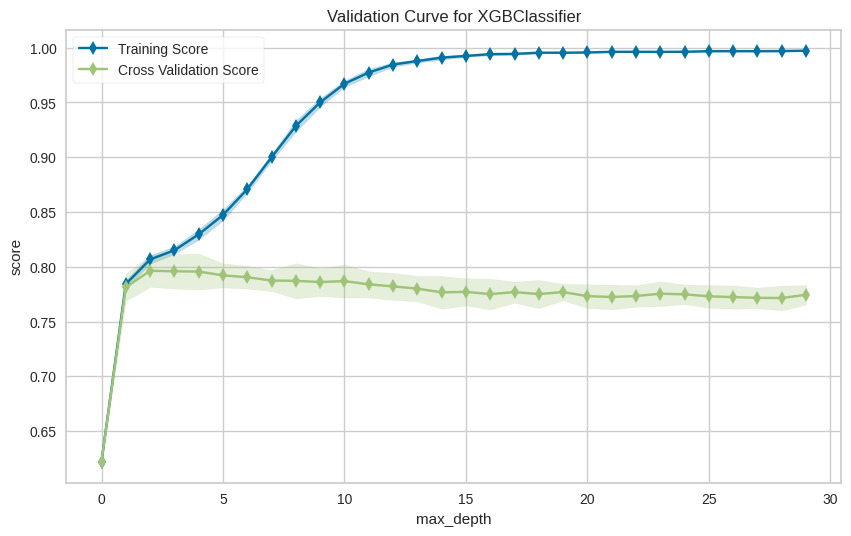

In [47]:
#we check for the max_depth argument 

from sklearn.model_selection import StratifiedKFold

n_splits = StratifiedKFold(n_splits= 6)
fig, ax = plt.subplots(figsize = (10, 6), dpi = 100)

viz_depth = ValidationCurve(xgb_model, param_name='max_depth', param_range= np.arange(0, 30, 1), ax = ax, cv = n_splits, scoring= 'f1_weighted', n_jobs= -1)
viz_depth.fit(X_train, y_train)
viz_depth.poof();

In [48]:
viz_depth.param_range[viz_depth.test_scores_mean_.argmax()]

2

In [49]:
viz_depth.test_scores_mean_

array([0.62226611, 0.78123387, 0.79634841, 0.79589906, 0.79561674,
       0.79216714, 0.79050362, 0.78743258, 0.78718359, 0.78606701,
       0.7869361 , 0.78395581, 0.78211457, 0.78006081, 0.77667649,
       0.77712884, 0.77508888, 0.77687869, 0.77511375, 0.77693107,
       0.7731876 , 0.77243287, 0.7733171 , 0.77546131, 0.7748738 ,
       0.77303872, 0.77235577, 0.77164135, 0.77149836, 0.77445093])

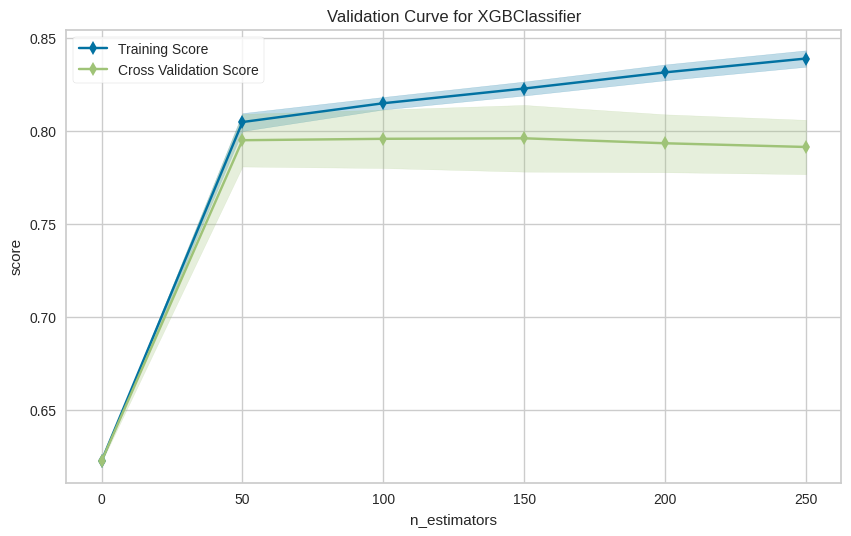

In [50]:
#we check for the number of estimators 
from sklearn.model_selection import StratifiedKFold

n_splits = StratifiedKFold(n_splits= 6)
fig, ax = plt.subplots(figsize = (10, 6), dpi = 100)

viz_estimators = ValidationCurve(xgb_model, param_name='n_estimators', param_range= np.arange(0, 300, 50), ax = ax, cv = n_splits, scoring= 'f1_weighted', n_jobs= -1)
viz_estimators.fit(X_train, y_train)
viz_estimators.poof();

In [51]:
viz_estimators.param_range[viz_estimators.test_scores_mean_.argmax()]

150

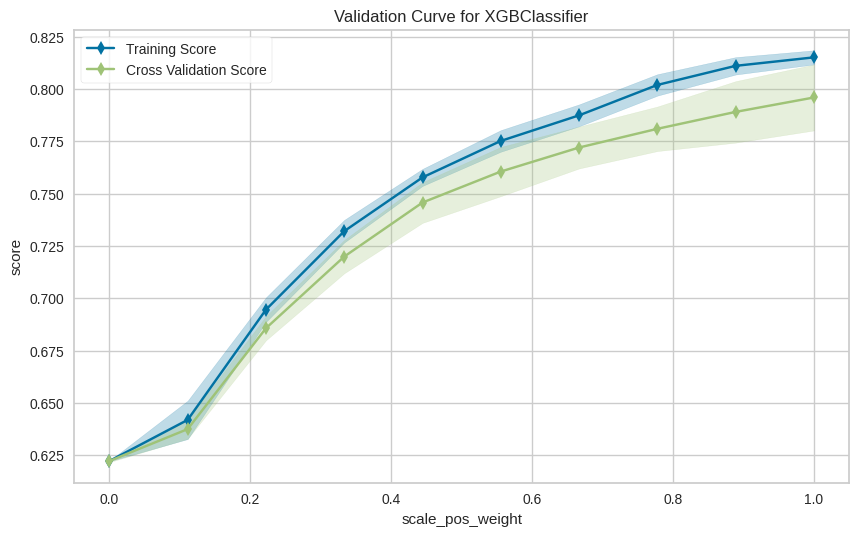

In [52]:
#we check for the scale_pos_weight argument i.e., for cases of data imbalance

from sklearn.model_selection import StratifiedKFold

n_splits = StratifiedKFold(n_splits= 6)
fig, ax = plt.subplots(figsize = (10, 6), dpi = 100)

viz_pos_weight = ValidationCurve(xgb_model, param_name='scale_pos_weight', param_range= np.linspace(0, 1, 10), ax = ax, cv = n_splits, scoring= 'f1_weighted', n_jobs= -1)
viz_pos_weight.fit(X_train, y_train)
viz_pos_weight.poof();

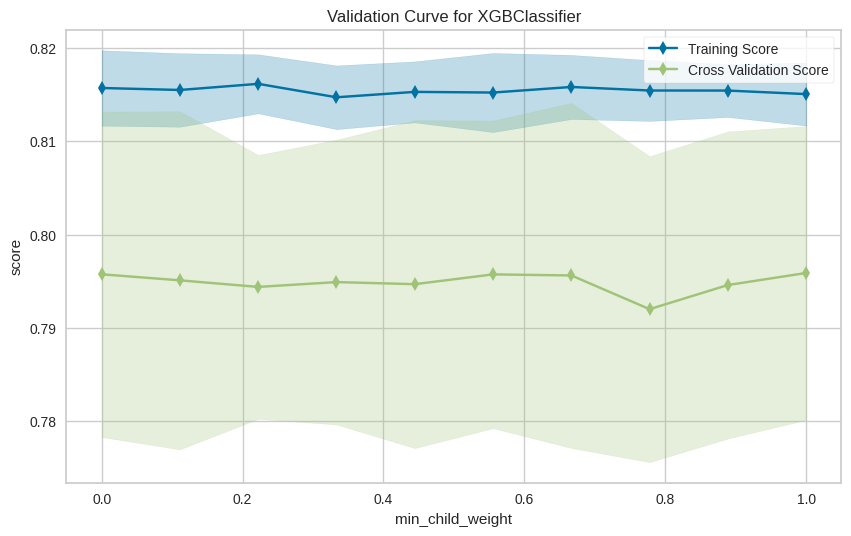

In [53]:
#we check for the min_child_weight argument 

from sklearn.model_selection import StratifiedKFold

n_splits = StratifiedKFold(n_splits= 6)
fig, ax = plt.subplots(figsize = (10, 6), dpi = 100)

viz_min_child_weight = ValidationCurve(xgb_model, param_name='min_child_weight', param_range= np.linspace(0, 1, 10), ax = ax, cv = n_splits, scoring= 'f1_weighted', n_jobs= -1)
viz_min_child_weight.fit(X_train, y_train)
viz_min_child_weight.poof();

In [54]:
viz_min_child_weight.param_range[viz_min_child_weight.test_scores_mean_.argmax()]

1.0

In [55]:
viz_min_child_weight.test_scores_mean_

array([0.79575714, 0.79510965, 0.79440582, 0.79492217, 0.79469832,
       0.7957464 , 0.79563391, 0.79202313, 0.7946085 , 0.79589906])

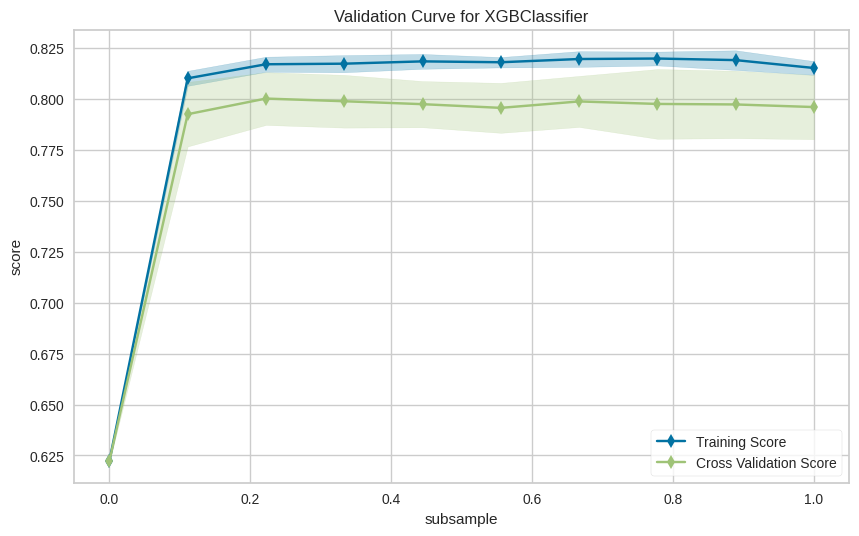

In [56]:
#we check for the subsample argument i.e., percentage of total observation to use for each training/tree building

from sklearn.model_selection import StratifiedKFold

n_splits = StratifiedKFold(n_splits= 6)
fig, ax = plt.subplots(figsize = (10, 6), dpi = 100)

viz_subsample = ValidationCurve(xgb_model, param_name='subsample', param_range= np.linspace(0, 1, 10), ax = ax, cv = n_splits, scoring= 'f1_weighted', n_jobs= -1)
viz_subsample.fit(X_train, y_train)
viz_subsample.poof();

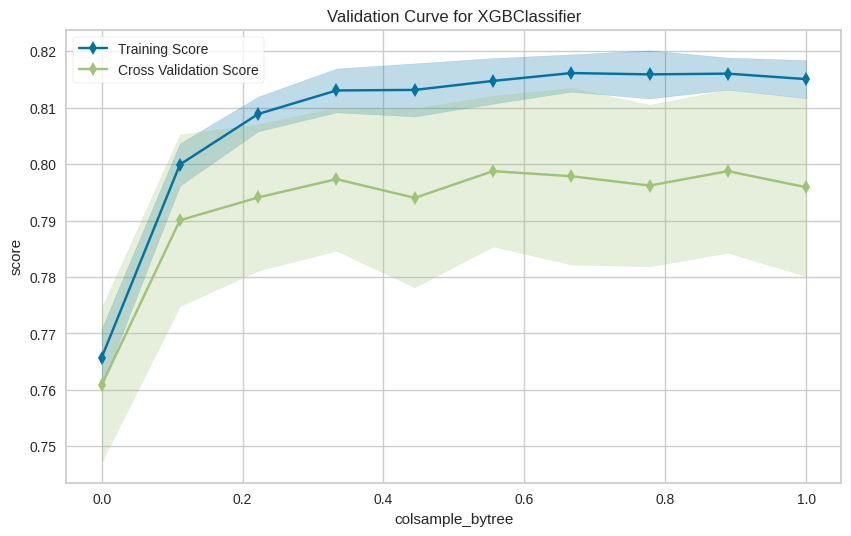

In [57]:
#we check for the colsample argument i.e., percentage of total features to use for each training/tree building

from sklearn.model_selection import StratifiedKFold

n_splits = StratifiedKFold(n_splits= 6)
fig, ax = plt.subplots(figsize = (10, 6), dpi = 100)

viz_colsample = ValidationCurve(xgb_model, param_name='colsample_bytree', param_range= np.linspace(0, 1, 10), ax = ax, cv = n_splits, scoring= 'f1_weighted', n_jobs= -1)
viz_colsample.fit(X_train, y_train)
viz_colsample.poof();

In [58]:
viz_colsample.param_range[viz_colsample.test_scores_mean_.argmax()]

0.5555555555555556

##time to tune our hyperparameters and build a new model

In [59]:
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline

In [60]:
from sklearn.metrics import f1_score

In [61]:
steps = [('kbest', SelectKBest(f_classif)), ('scaler', StandardScaler()), ('imputer', SimpleImputer()) ,('xgboost', xgb.XGBClassifier(objective='binary:logistic',random_state= 42, n_jobs= -1, missing = None))]

In [62]:
pipeline = Pipeline(steps)

In [63]:
params = [{'kbest__k': np.arange(1, len(X_train.columns), 1), 'xgboost__reg_alpha': [0.7], 'xgboost__max_depth': [2, 3], 'xgboost__learning_rate':[0.11], 
                'xgboost__n_estimators': [150], 'xgboost__gamma': [0.88, 0.9], 'xgboost__scale_pos_weight':[1],
                'xgboost__min_child_weight': [0.7, 0.8], 'xgboost__subsample': [0.3], 'xgboost__colsample_bytree': [0.5]}]

#build the grid search

In [64]:
gridsearch = GridSearchCV(pipeline, param_grid= params, scoring = make_scorer(f1_score, average = 'weighted'), cv = n_splits, return_train_score= True, n_jobs = -1)

In [65]:
#fit it to the training dataset 
grid_model = gridsearch.fit(X_train, y_train)

In [66]:
grid_model.best_score_

0.8003384254622241

In [67]:
grid_model.best_params_

{'kbest__k': 27,
 'xgboost__colsample_bytree': 0.5,
 'xgboost__gamma': 0.88,
 'xgboost__learning_rate': 0.11,
 'xgboost__max_depth': 2,
 'xgboost__min_child_weight': 0.7,
 'xgboost__n_estimators': 150,
 'xgboost__reg_alpha': 0.7,
 'xgboost__scale_pos_weight': 1,
 'xgboost__subsample': 0.3}

In [68]:
#check for overfitting 
grid_cv = grid_model.cv_results_

In [69]:
np.mean(grid_cv['mean_train_score']), np.mean(grid_cv['mean_test_score'])

(0.7971672059865398, 0.7854452600781333)

There is no overfit in the dataset

##below we have the predictions and their probabilities

In [70]:
y_pred = grid_model.predict(X_test)
y_pred_proba = grid_model.predict_proba(X_test)

below I am threshold holding the probabilities to 0.6

#Model evaluation

In [71]:
[s[1] > 0.6 for s in y_pred_proba] == y_pred

array([False, False, False, ..., False, False, False])

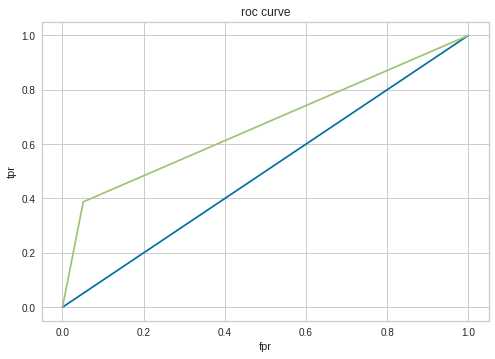

In [94]:
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder
fpr, tpr, threshold = roc_curve(LabelEncoder().fit_transform(y_test), LabelEncoder().fit_transform([s[1] > 0.6 for s in y_pred_proba]))

plt.plot([0, 1], [0, 1])
plt.plot(fpr, tpr)
plt.title('roc curve')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.show();


In [90]:
from sklearn.metrics import roc_auc_score
roc_auc_score(LabelEncoder().fit_transform(y_test), LabelEncoder().fit_transform([s[1] > 0.6 for s in y_pred_proba]))

0.6682464026453795

In [99]:
confusion_mat = pd.DataFrame(confusion_matrix(LabelEncoder().fit_transform(y_test), LabelEncoder().fit_transform([s[1] > 0.6 for s in y_pred_proba])))
confusion_mat

,0,1
0,982,53
1,229,145


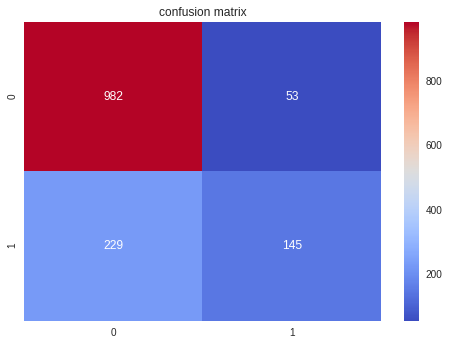

In [111]:
sns.heatmap(confusion_mat, annot= True, cmap = 'coolwarm', fmt = '.3g')
plt.title('confusion matrix');
plt.show();

##Below we plot the classifcation report 

In [118]:
from yellowbrick.classifier import ClassificationReport

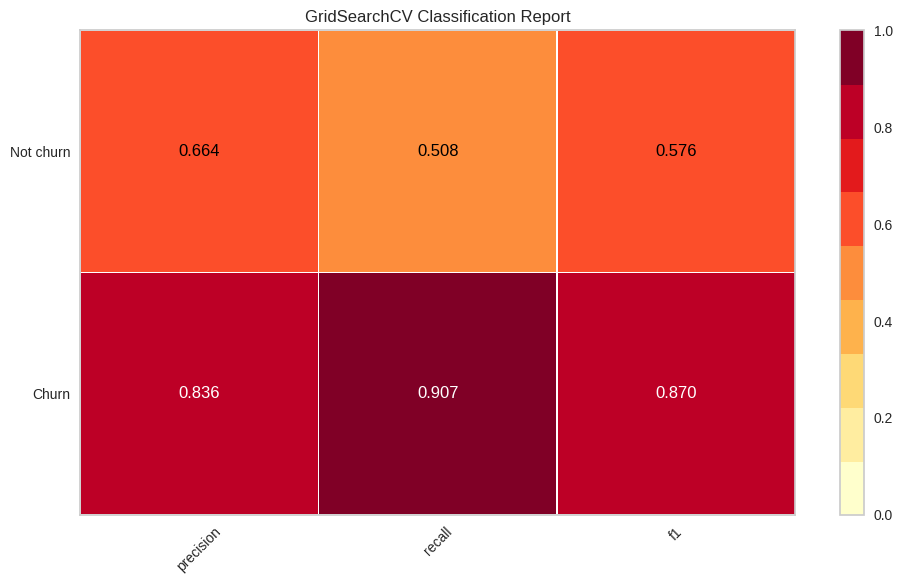

In [119]:
fig, ax = plt.subplots(figsize = (10,6), dpi =100)
class_rep = ClassificationReport(grid_model, classes= ['Churn', 'Not churn'], ax = ax, support = True)
class_rep.fit(X_train, y_train)
class_rep.score(X_test, y_test)
class_rep.poof();

#Evaluating the quality of each xgboosted tree

In [133]:
print(grid_model.best_estimator_[3].get_booster().get_dump()[70])

0:[f4<0.0312541723] yes=1,no=2,missing=1
	1:[f2<1.05531788] yes=3,no=4,missing=3
		3:leaf=0.0039454475
		4:leaf=0.0762896314
	2:[f2<-0.713797808] yes=5,no=6,missing=5
		5:leaf=0.0143027036
		6:leaf=-0.0239154883



#plotting an xgboost tree

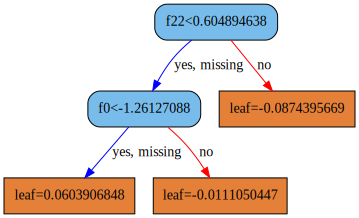

In [134]:
cnode_params = {'shape':'box',
           'style':'filled,rounded',
           'fillcolor':'#78bceb'
    }

lnode_params = {'shape':'box',
           'style':'filled',
           'fillcolor':'#e48038'
    }


xgb.to_graphviz(grid_model.best_estimator_[3], num_trees= 19, condition_node_params= cnode_params, leaf_node_params= lnode_params, size = "10.10")